Loading data for seasons: ['21-22', '22-23', '23-24', '24-25']
  Loaded 21-22.csv ((30, 15))
  Loaded 22-23.csv ((30, 15))
  Loaded 23-24.csv ((30, 15))
  Loaded 24-25.csv ((30, 15))

Combined data shape: (120, 15)

--- Analyzing Feature Importance for Target: Wins ---
Index(['SEASON', 'TEAM_NAME', 'TEAM_ID', 'Wins', 'ORTG', 'DRTG', 'eFG_Percent',
       'TS_Percent', 'TOV_Percent', 'FG3_Percent', 'FG_Percent',
       'Team_3s_Attempted', 'Team_2s_Attempted', 'Weighted_Avg_Height',
       'Weighted_Avg_Wingspan'],
      dtype='object')
  Training data shape: (90, 9), Test data shape: (30, 9)
  Model R-squared on Test Set: 0.874


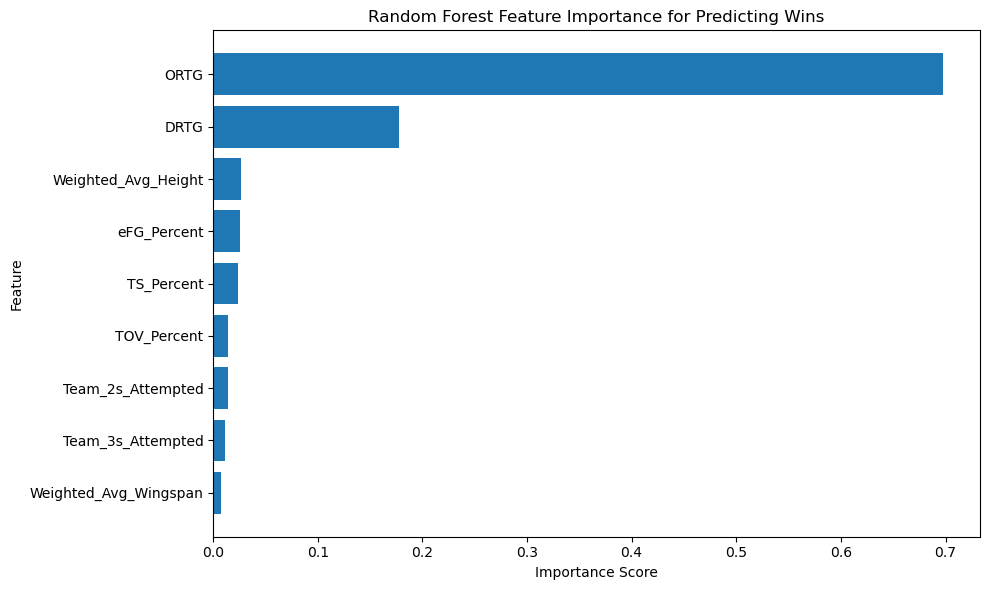


--- Analyzing Feature Importance for Target: ORTG ---
Index(['SEASON', 'TEAM_NAME', 'TEAM_ID', 'Wins', 'ORTG', 'DRTG', 'eFG_Percent',
       'TS_Percent', 'TOV_Percent', 'FG3_Percent', 'FG_Percent',
       'Team_3s_Attempted', 'Team_2s_Attempted', 'Weighted_Avg_Height',
       'Weighted_Avg_Wingspan'],
      dtype='object')
  Training data shape: (90, 8), Test data shape: (30, 8)
  Model R-squared on Test Set: 0.673


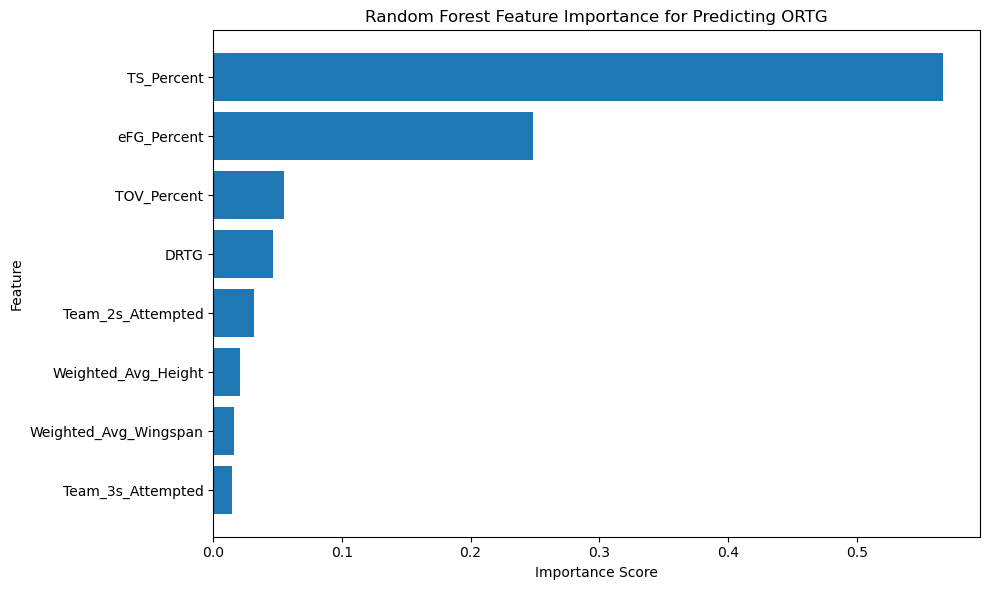


--- Analyzing Feature Importance for Target: DRTG ---
Index(['SEASON', 'TEAM_NAME', 'TEAM_ID', 'Wins', 'ORTG', 'DRTG', 'eFG_Percent',
       'TS_Percent', 'TOV_Percent', 'FG3_Percent', 'FG_Percent',
       'Team_3s_Attempted', 'Team_2s_Attempted', 'Weighted_Avg_Height',
       'Weighted_Avg_Wingspan'],
      dtype='object')
  Training data shape: (90, 8), Test data shape: (30, 8)
  Model R-squared on Test Set: -0.041


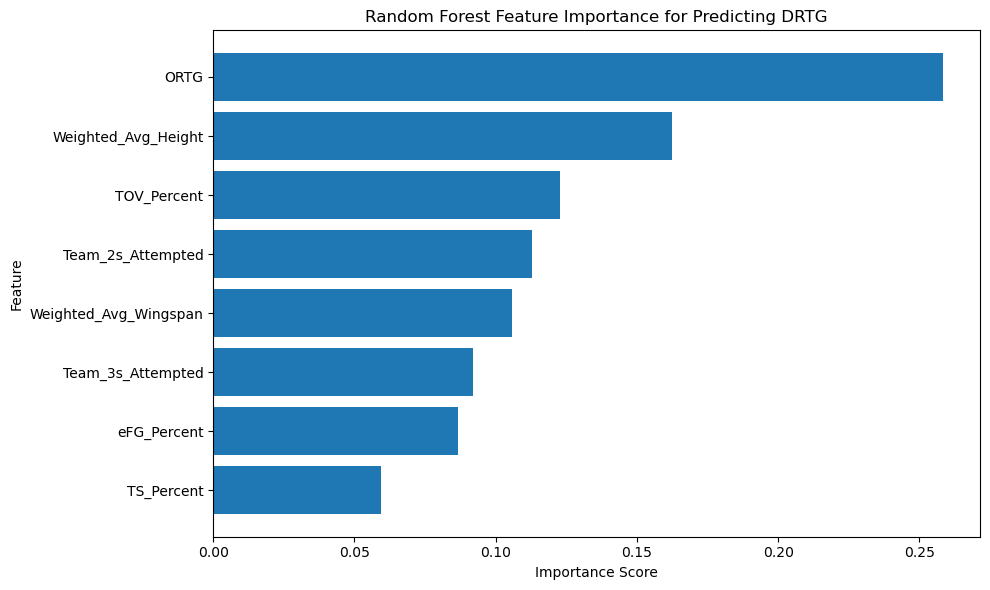


--- Feature Importance Analysis Complete ---


In [16]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import shap # For SHAP analysis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
# Or use XGBoost/LightGBM:
# import xgboost as xgb 
# import lightgbm as lgb

# --- 1. Load and Prepare Data ---
# Define the path where the clean data files are located
load_path = '../../Project-8---Sports-Analysis/data/cleandata/' # Adjust if needed
start_year = 2021
end_year = 2024 # Adjust if needed
seasons = [f"{str(year)[-2:]}-{str(year+1)[-2:]}" for year in range(start_year, end_year + 1)] 

all_data = []
print(f"Loading data for seasons: {seasons}")

for season in seasons:
    file_path = os.path.join(load_path, f'{season}.csv')
    if os.path.exists(file_path):
        try:
            df = pd.read_csv(file_path)
            all_data.append(df)
            print(f"  Loaded {season}.csv ({df.shape})")
        except Exception as e:
            print(f"  Error loading {file_path}: {e}")
    else:
        print(f"  Warning: File not found {file_path}")

if not all_data:
    print("Error: No data loaded. Exiting.")
    exit()

combined_df = pd.concat(all_data, ignore_index=True)
print(f"\nCombined data shape: {combined_df.shape}")

# Basic Cleaning - Handle potential NaNs (e.g., from weighted averages)
# Strategy: Fill with median for simplicity, or consider more advanced imputation/dropping
numeric_cols = combined_df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    if combined_df[col].isnull().any():
        median_val = combined_df[col].median()
        combined_df[col].fillna(median_val, inplace=True)
        print(f"  Filled NaNs in '{col}' with median ({median_val:.2f})")

# --- 2. Define Targets and Features ---

# List of target variables we want to analyze the drivers for
targets = ['Wins', 'ORTG', 'DRTG'] 

# Potential features (adjust based on exact columns in your CSVs)
# Exclude identifiers and the target variable itself during each iteration
potential_features = [
    'ORTG', 'DRTG', 'TOV_Percent', 'Team_3s_Attempted', 'Team_2s_Attempted', 
    'Weighted_Avg_Height', 'Weighted_Avg_Wingspan', 'eFG_Percent', 'TS_Percent'
    # Add any other relevant numeric columns you have
]
# Ensure all target names are also in potential_features if they should act as predictors for others

# --- 3. Loop Through Targets for Analysis ---

for target in targets:
    print(f"\n--- Analyzing Feature Importance for Target: {target} ---")
    
    # Define features (X) and target (y) for this iteration
    print(combined_df.columns)
    current_features = [f for f in potential_features if f != target and f in combined_df.columns]
    
    if not current_features:
        print(f"  No valid features found for target {target}. Skipping.")
        continue
        
    X = combined_df[current_features]
    y = combined_df[target]

    if X.empty or y.empty:
        print(f"  Feature set or target is empty for {target}. Skipping.")
        continue

    # Split data for reliable evaluation/SHAP analysis
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    print(f"  Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

    # --- 4. Train Model ---
    # Using RandomForestRegressor. XGBoost or LightGBM are also great choices.
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) 
    # model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    # model = lgb.LGBMRegressor(random_state=42)
    
    model.fit(X_train, y_train)

    # Optional: Evaluate model performance on test set
    score = model.score(X_test, y_test) # R-squared score
    print(f"  Model R-squared on Test Set: {score:.3f}")

    # --- 5. Model-Based Feature Importance ---
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': current_features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.title(f"Random Forest Feature Importance for Predicting {target}")
    plt.gca().invert_yaxis() # Display most important features at the top
    plt.tight_layout()
    plt.show()


print("\n--- Feature Importance Analysis Complete ---")